<a href="https://colab.research.google.com/github/lsteffenel/M2Atmo_et_Climat/blob/main/03-Arbres%20et%20Forets%20aleatoires-2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Apprentissage supervisé: Arbres de décision et Forêts d'arbres aléatoires (Random Forests)

Intéressons nous maintenant à un des algorithmes les plus popualires de l'état de l'art. Cet algorithme est non-paramétrique et porte le nom de **forêts d'arbres aléatoires**

In [14]:
!wget https://github.com/lsteffenel/M2Atmo_et_Climat/raw/main/fig_code/fig_code.tar.gz
!tar -xzf fig_code.tar.gz

--2025-10-07 09:35:19--  https://github.com/lsteffenel/M2Atmo_et_Climat/raw/main/fig_code/fig_code.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lsteffenel/M2Atmo_et_Climat/main/fig_code/fig_code.tar.gz [following]
--2025-10-07 09:35:19--  https://raw.githubusercontent.com/lsteffenel/M2Atmo_et_Climat/main/fig_code/fig_code.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13606 (13K) [application/octet-stream]
Saving to: ‘fig_code.tar.gz.1’

fig_code.tar.gz.1   100%[===================>]  13.29K  --.-KB/s    in 0s      

2025-10-07 09:35:19 (56.1 MB/s) - ‘fig_code.tar.gz.1’ saved [

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#plt.style.use('seaborn')

## A l'origine des forêts d'arbres aléatoires : l'arbre de décision

Les fôrets aléatoires appartiennent à la famille des méthodes d'**apprentissage ensembliste** et sont construits à partir d'**arbres de décision**. Pour cette raison, nous allons tout d'abord présenter les arbres de décisions.

Un arbre de décision est une manière très intuitive de résoudre un problème de classification. On se contente de définir un certain nombre de questions qui vont permetre d'identifier la classe adéquate.

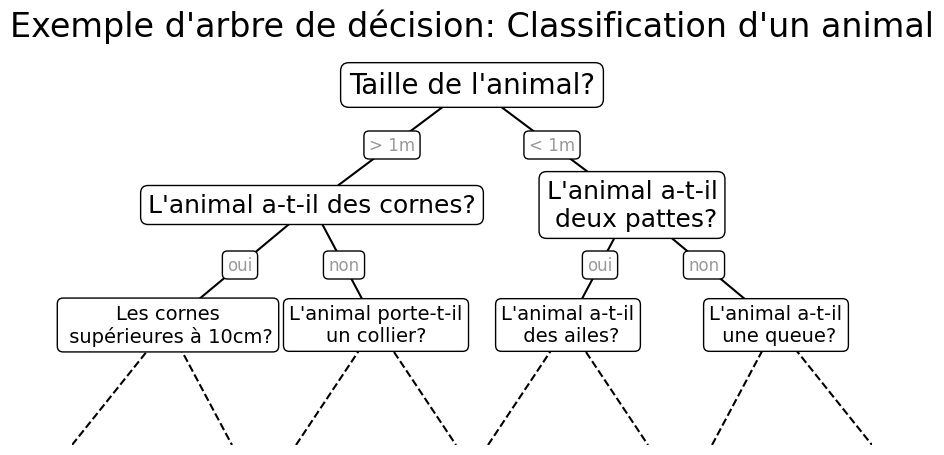

In [16]:
import fig_code.figures as fig
fig.plot_example_decision_tree()

Le découpage binaire des données est rapide a mettre en oeuvre. La difficulté va résider dans la manière de déterminer quelle est la "bonne" question à poser.

C'est tout l'enjeu de la phase d'apprentissage d'un arbre de décision. L'algorithme va déterminer, au vue d'un ensemble de données, quelle question (ou découpage...) va apporter le plus gros gain d'information.

### Construction d'un arbre de décision
Voici un exemple de classifieur à partir d'un arbre de décision en utlisiant la libraire scikit-learn.

Nous commencons par définir un jeu de données en 2 dimensions avec des labels associés:

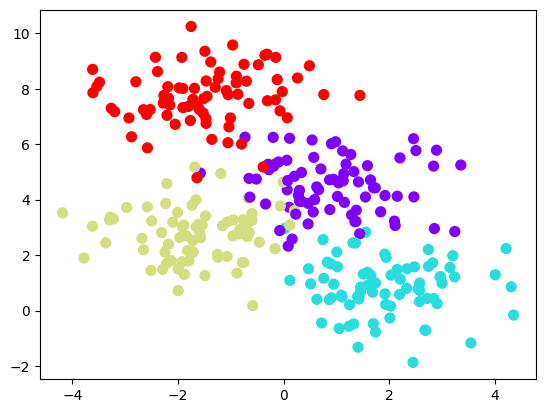

In [17]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Nous avons précemment défini une fonction qui va faciliter la visualisation du processus :

In [18]:
from fig_code.figures import visualize_tree, plot_tree_interactive

On utilise maintenant le module ``interact`` dans Ipython pour visualiser les découpages effectués par l'arbre de décision en fonction de la profondeur de l'arbre (*depth* en anglais), i.e. le nombre de questions que l'arbre peut poser :

In [19]:
plot_tree_interactive(X, y);

interactive(children=(IntSlider(value=1, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

**Remarque** : à chaque augmentation de la profondeur de l'arbre, chaque branche est découpée en deux **à l'expection** des branches qui contiennent uniquement des points d'une unique classe.

L'arbre de décision est une méthode de classification non paramétrique facile à mettre en oeuvre

**Question: Observez-vous des problèmes avec cette modélisation ?**

## Arbre de décision et sur-apprentissage

Un problème avec les arbres de décision est qu'ils ont tendance à **sur-apprendre** rapidement sur les données d'apprentissage. En effet, ils ont une forte tendance à capturer le bruit présent dans les données plutôt que la vraie distribution recherchée. Par exemple, si on construit 2 arbres à partir de sous ensembles des données définies précédemment, on obtient les deux classifieurs suivants:

<Figure size 640x480 with 0 Axes>

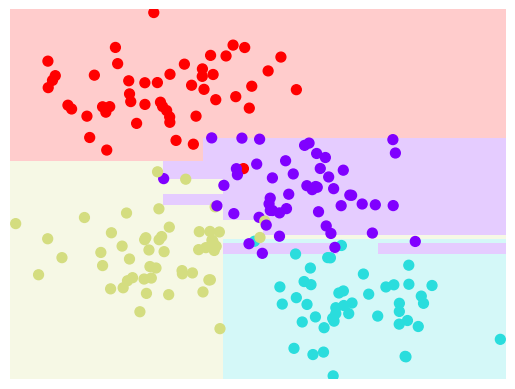

<Figure size 640x480 with 0 Axes>

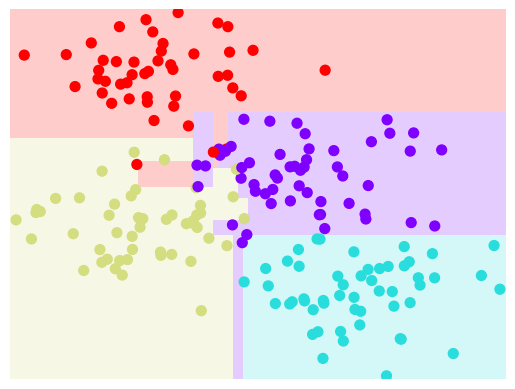

In [20]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

plt.figure()
visualize_tree(clf, X[:200], y[:200], boundaries=False)
plt.figure()
visualize_tree(clf, X[-200:], y[-200:], boundaries=False)

Les 2 classifieurs ont des différences notables si on regarde en détails les figures. Lorsque'on va prédire la classe d'un nouveau point, cela risque d'être impacté par le bruit dans les données plus que par le signal que l'on cherche à modéliser.


## Prédictions ensemblistes: Forêts aléatoires
Une façon de limiter ce problème de sur-apprentissage est d'utiliser un **modèle ensembliste**: un méta-estimateur qui va aggréger les predictions de mutliples estimateurs (qui peuvent sur-apprendre individuellement). Grace à des propriétés mathématiques plutôt magiques (!), la prédiction aggrégée de ces estimateurs s'avère plus performante et robuste que les performances des estimateurs considérés individuellement.

Une des méthodes ensemblistes les plus célèbres est la méthode des **forêts d'arbres aléatoires** qui aggrège les prédictions de multiples arbres de décision.

Il y a beaucoup de littératures scientifiques pour déterminer la façon de rendre aléatoires ces arbres mais donner un exemple concret, voici un ensemble de modèle qui utilise seulement un sous échantillon des données :


In [21]:
X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)

def fit_randomized_tree(random_state=0):
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)

    clf = DecisionTreeClassifier(max_depth=5)
    #on utilise seulement 250 exemples choisis aléatoirement sur les 300 disponibles
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))

from ipywidgets import interact
interact(fit_randomized_tree, random_state=(0, 100));

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

On peut observer dans le détail les changements du modèle en fonction du tirage aléatoire des données qu'il utilise pour l'apprentissage, alors que la distribution des données est figée !

La forêt aléatoire va faire des caluls similaires, mais va aggréger l'ensemble des arbres aléatoires générés pour construire une unique prédiction:

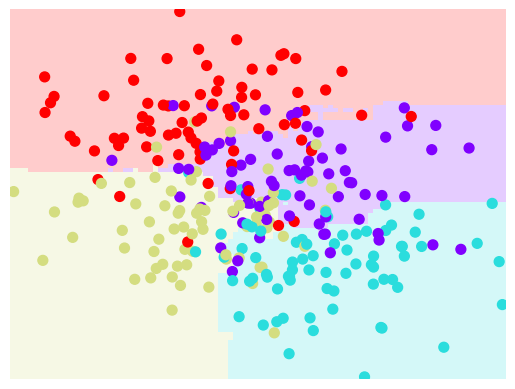

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
visualize_tree(clf, X, y, boundaries=False);

En moyennant 100 arbres de décision "perturbés" aléatoirement, nous obtenons une prédiction aggrégé qui modélise avec plus de précision nos données.

*(Remarque: ci dessus, notre perturbation aléatoire est effectué en echantillonant de manière aléatoire nos données... Les arbres aléatoires utilisent des techniques plus sophistiquées, pour plus de détails voir la [documentation de scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html#forest)*)